In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import cv2
import os

In [77]:
NUM_CLASSES = 16

def int_to_class(predicted_class):
    dict = {
        0 : '0',
        1 : '1',
        2 : '2',
        3 : '3',
        4 : '4',
        5 : '5',
        6 : '6',
        7 : '7',
        8 : '8',
        9 : '9',
        10 : '+',
        11 : '-',
        12 : '*',
        13 : '/',
        14 : '[',
        15 : ']'
    }
    return dict[predicted_class]

model_weights_file_output_path = "./expression_classifier_model.ckpt"
data_input_folder_path = "./data/numbers_operations_split"

train_data = np.load(os.path.join(data_input_folder_path, "numbers_operations_train.npy"))
val_data = np.load(os.path.join(data_input_folder_path, "numbers_operations_val.npy"))
test_data = np.load(os.path.join(data_input_folder_path, "numbers_operations_test.npy"))

x_train, y_train = np.array([arr[:-1] for arr in train_data]), np.array([arr[-1] for arr in train_data])
x_val, y_val = np.array([arr[:-1] for arr in val_data]), np.array([arr[-1] for arr in val_data])
x_test, y_test = np.array([arr[:-1] for arr in test_data]), np.array([arr[-1] for arr in test_data])

print("Number of training samples:", len(train_data))
print("Number of validation samples:", len(val_data))
print("Number of test samples:", len(test_data))

Number of training samples: 267109
Number of validation samples: 33390
Number of test samples: 33396


Convolutional neural network with ReLu activation and Adam optimizer from:
"CNN Model for Image Classification on MNIST and Fashion-MNIST Dataset" by Kadam, Shivam S. et. al. published in Journal of Scientific Research Volume 64, Issue 2, 2020

In [36]:
# Function for creating model
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Reshape((28, 28, 1)),
        tf.keras.layers.Rescaling(1./255, input_shape=(28, 28, 1)),

        tf.keras.layers.Conv2D(32, (3, 3), input_shape=(28, 28, 1), activation='relu'),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Dropout(rate=0.25),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Dropout(rate=0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(NUM_CLASSES),
        tf.keras.layers.Softmax()
    ])

    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.00005),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
    
    return model


Epoch 1/20
7513/7513 [==============================] - 96s 13ms/step - loss: 0.7254 - accuracy: 0.7687 - val_loss: 0.2877 - val_accuracy: 0.9098
Epoch 2/20
7513/7513 [==============================] - 102s 14ms/step - loss: 0.3316 - accuracy: 0.8938 - val_loss: 0.1813 - val_accuracy: 0.9420
Epoch 3/20
7513/7513 [==============================] - 101s 13ms/step - loss: 0.2307 - accuracy: 0.9264 - val_loss: 0.1349 - val_accuracy: 0.9559
Epoch 4/20
7513/7513 [==============================] - 103s 14ms/step - loss: 0.1843 - accuracy: 0.9412 - val_loss: 0.1084 - val_accuracy: 0.9632
Epoch 5/20
7513/7513 [==============================] - 107s 14ms/step - loss: 0.1562 - accuracy: 0.9496 - val_loss: 0.0974 - val_accuracy: 0.9665
Epoch 6/20
7513/7513 [==============================] - 104s 14ms/step - loss: 0.1390 - accuracy: 0.9545 - val_loss: 0.0838 - val_accuracy: 0.9708
Epoch 7/20
7513/7513 [==============================] - 104s 14ms/step - loss: 0.1248 - accuracy: 0.9590 - val_loss: 0.

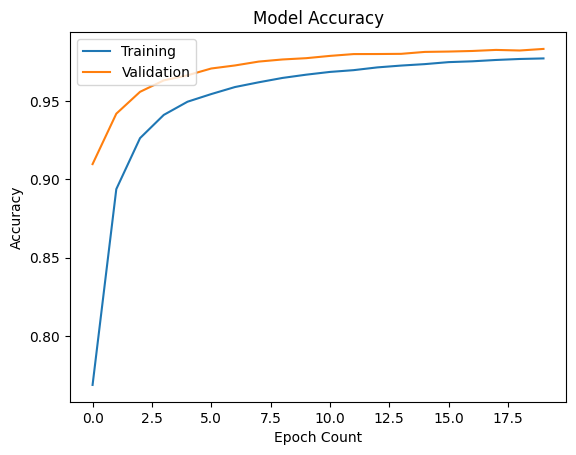

INFO:tensorflow:Assets written to: ./expression_classifier_model.ckpt/assets


INFO:tensorflow:Assets written to: ./expression_classifier_model.ckpt/assets


In [38]:
# Train and save model
model = create_model()

# Train model
training_history = model.fit(np.stack(x_train), y_train, validation_split=0.1, epochs=20)

# Plot training metrics
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch Count')
plt.legend(['Training', "Validation"], loc='upper left')
plt.show()

# Save model
model.save(model_weights_file_output_path)

In [53]:
# Load model
model = create_model()
model.load_weights(model_weights_file_output_path)

2023-09-21 21:15:45.125952: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ./expression_classifier_model.ckpt: FAILED_PRECONDITION: expression_classifier_model.ckpt; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [78]:
def performance_metrics(model, x_data, y_data):
    predictions = [np.argmax(arr) for arr in model.predict(np.stack(x_data))]
    score = model.evaluate(x_data, y_data, verbose=0)
    loss = score[0]
    accuracy = score[1]

    num_positives = [0] * NUM_CLASSES # Number of times a number appears in y_data
    num_true_positives = [0] * NUM_CLASSES # Number of times we correctly predicted each class
    num_predictions = [0] * NUM_CLASSES # Number of times we predicted each class
    for i in range(len(y_data)):
        num_positives[y_data[i]] += 1
        num_predictions[predictions[i]] += 1
        if (y_data[i] == predictions[i]):
            num_true_positives[y_data[i]] += 1
    
    recall = [num_true_positives[i] / num_positives[i] for i in range(NUM_CLASSES)]
    precision = [num_true_positives[i] / num_predictions[i] for i in range(NUM_CLASSES)]
    f1_score = [(2 * recall[i] * precision[i]) / (recall[i] + precision[i]) for i in range(NUM_CLASSES)]

    NUM_ROUND_DIGITS = 5

    return {"loss" : round(loss, NUM_ROUND_DIGITS), 
            "accuracy" : round(accuracy, NUM_ROUND_DIGITS), 
            "precision" : [round(x, NUM_ROUND_DIGITS) for x in precision], 
            "recall" : [round(x, NUM_ROUND_DIGITS) for x in recall], 
            "f1" : [round(x, NUM_ROUND_DIGITS) for x in f1_score]}

# Display the predictions on x_data and x_data images in N_ROWS by N_COLS grids
def display_predictions(model, x_data, N_ROWS, N_COLS):
    # Predictions on data set
    predictions = [np.argmax(arr) for arr in model.predict(np.stack(x_data))]

    # Create subplot for display
    fig, ax = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(3,3))
    np.vectorize(lambda axis : axis.axis("off"))(ax) # Turn of axis labels

    images = [Image.fromarray(np.reshape(arr.astype('uint8'), (28, 28))) for arr in x_data]

    # Display images of data set
    img_count = 0
    for i in range(N_ROWS):
        for j in range(N_COLS):        
            if img_count < len(images):
                ax[i, j].imshow(images[img_count])
                img_count+=1

    # Display predictions on data set
    value_count = 0
    for i in range(N_ROWS):
        for j in range(N_COLS):
            if value_count < len(predictions):
                print(int_to_class(predictions[value_count]), end=' ')
                value_count += 1
        print('')

1044/1044 [==============================] - 4s 3ms/step
loss 0.04555
accuracy 0.98524
precision [0.99655, 0.98251, 0.99271, 0.9954, 0.99352, 0.99566, 0.99903, 0.98871, 0.99758, 0.99118, 0.99002, 0.98597, 0.99704, 0.90878, 0.9875, 0.98058]
recall [0.99951, 0.93719, 0.99513, 0.9954, 0.9894, 0.9971, 0.99709, 0.97519, 0.99952, 0.98875, 0.98778, 0.98968, 0.99606, 0.98137, 0.97918, 0.95183]
f1 [0.99803, 0.95932, 0.99392, 0.9954, 0.99145, 0.99638, 0.99806, 0.9819, 0.99855, 0.98996, 0.9889, 0.98782, 0.99655, 0.94368, 0.98332, 0.96599]
1044/1044 [==============================] - 3s 3ms/step
/ + - 4 2 5 8 7 9 3 
] 8 + 2 4 2 4 6 4 1 
5 [ 9 0 + 1 6 3 6 7 
+ - 2 2 0 8 6 0 6 3 
/ 1 9 + 5 4 6 0 7 9 
/ - 2 + 6 2 0 8 7 / 
3 5 6 6 4 ] * * 1 ] 
4 4 2 ] + 0 8 ] 2 4 
7 9 6 6 7 2 / + 2 5 
+ / 8 9 0 0 1 ] 1 3 


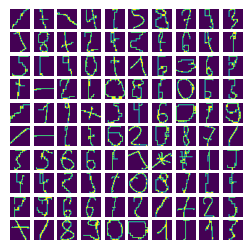

In [79]:
# Display predictions on validation set (always taken from end of data)
validation_metrics = performance_metrics(model, x_val, y_val)
for k, v in validation_metrics.items():
    print(k, v)
display_predictions(model, x_val, 10, 10)

In [80]:
# Predicts digit in image from a WHITE background
def predict_image(img_path):
    img = Image.open(img_path).convert('L')
    img = img.resize((28, 28))

    # Convert so white 255 becomes black 0
    arr = np.array(img)
    for i in range(28):
        for j in range(28):
            arr[i, j] = 255 - arr[i, j]
            
    return np.argmax(model.predict(np.stack([arr])))

def display_image(img_path):
    img = Image.open(img_path).convert('L')
    img = img.resize((28, 28))

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))
    np.vectorize(lambda axis : axis.axis("off"))(ax) # Turn of axis labels
    ax.imshow(img)

1/1 [==============================] - 0s 17ms/step
13


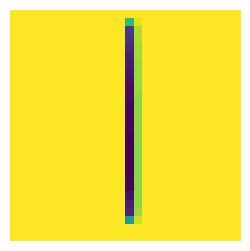

In [86]:
print(predict_image("./test_digits/1.png"))
display_image("./test_digits/1.png")

In [ ]:
# Predictions on images with multiple digits

image = cv2.imread('./testimg/digits2.png')
grey = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(grey.copy(), 75, 255, cv2.THRESH_BINARY_INV)
contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

preprocessed_digits = []
for c in contours:
    x,y,w,h = cv2.boundingRect(c)
    
    # Creating bounding box
    cv2.rectangle(image, (x,y), (x+w, y+h), color=(0, 255, 0), thickness=2)
    
    # Cropping out the digit from the image
    digit = thresh[y:y+h, x:x+w]
    
    # Resize image, but don't disproportionately scale it
    resized_width = min(20, int(1.25 * w))
    resized_height = min(20, int(1.25 * h))
    if resized_width % 2 == 1: resized_width += 1 # Must scale to even number so padding is same on both sides
    if resized_height % 2 == 1: resized_height += 1 # Must scale to even number so padding is same on both sides
    resized_digit = cv2.resize(digit, (resized_width, resized_height))
    

    remaining_pad_width = (28 - resized_width) // 2
    remaining_pad_height = (28 - resized_height) // 2
    padded_digit = np.pad(resized_digit, ((remaining_pad_height, remaining_pad_height),(remaining_pad_width, remaining_pad_width)), "constant", constant_values=0)

    preprocessed_digits.append(padded_digit)

plt.imshow(image, cmap="gray")
plt.show()
    

for digit in preprocessed_digits:
    prediction = model.predict(digit.reshape(1, 28, 28, 1))  
    
    plt.imshow(digit.reshape(28, 28), cmap="gray")
    plt.show()
    print("Predicted digit: {}".format(np.argmax(prediction)))
    print ("Probabilities from neural net: {}".format(prediction))